In [1]:
library(readr)
library(tidyverse)
library(forecast)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v dplyr   1.0.2
v tibble  3.0.4     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'forecast' was built under R version 4.0.5"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
leche = read_csv("https://github.com/SpikeLab-CL/desafio_spike_precios/raw/main/precio_leche.csv")


-- Column specification --------------------------------------------------------
cols(
  Anio = col_double(),
  Mes = col_character(),
  Precio_leche = col_double()
)




In [3]:
Precio = leche$Precio_leche
Precio <- ts(Precio, start = c(1979,1),frequency = 12)

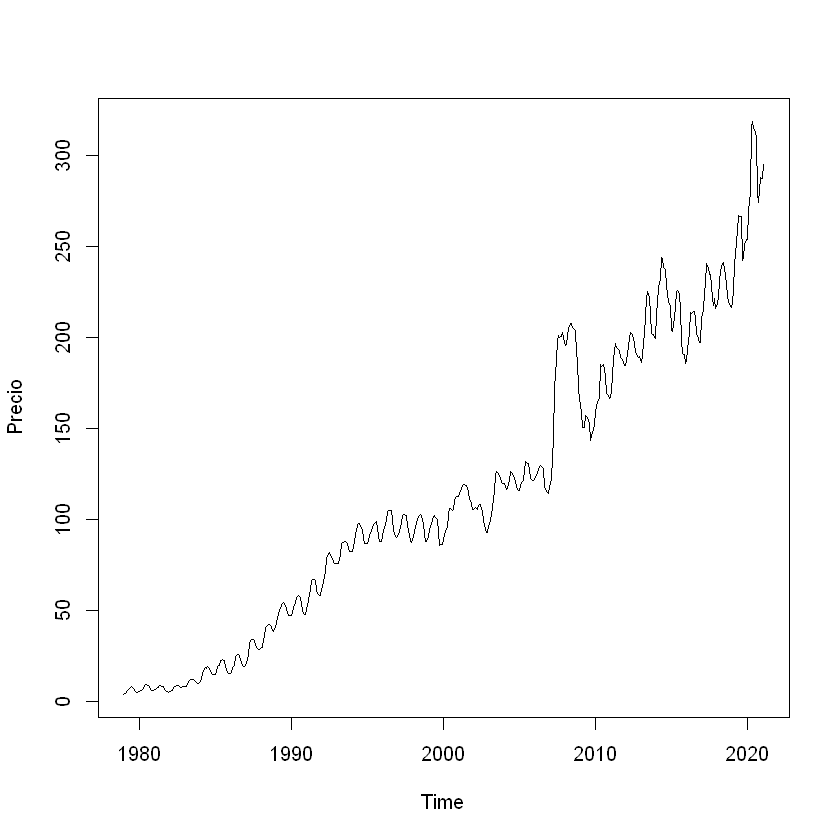

In [4]:
plot(Precio)

se dejará el último año para comparar resultados

In [5]:
Precio2 <- leche$Precio_leche[1:as.numeric(as.numeric(length(leche$Precio_leche))-12)]
Precio2 <- ts(Precio2, start = c(1979,1),frequency = 12)

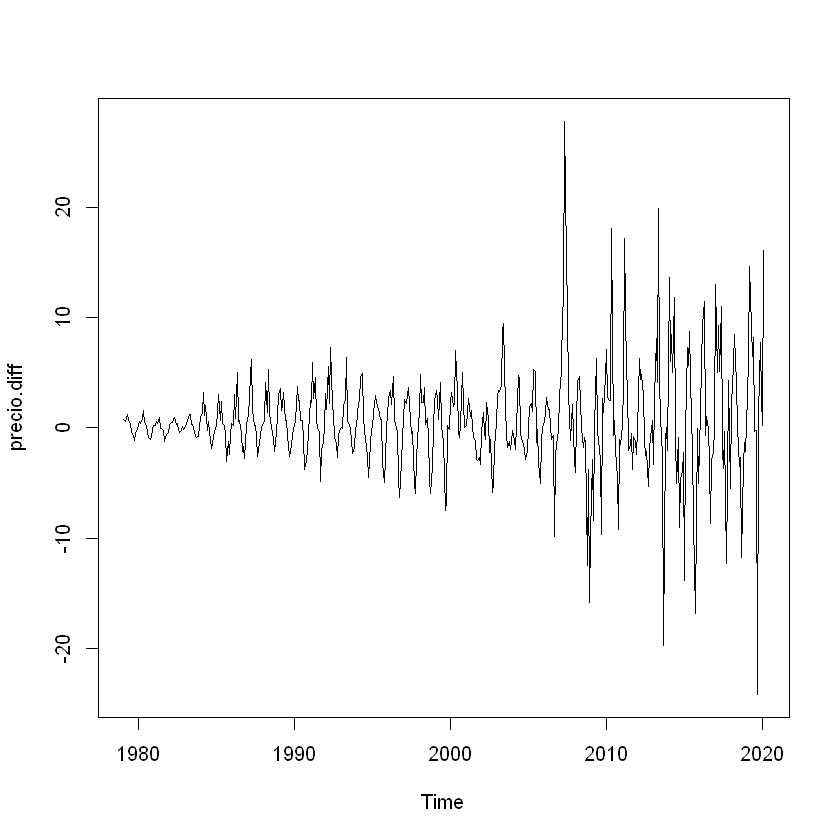

In [6]:
#Diferencia regular para eliminar tendencia
precio.diff <- diff(Precio2)
plot(precio.diff)

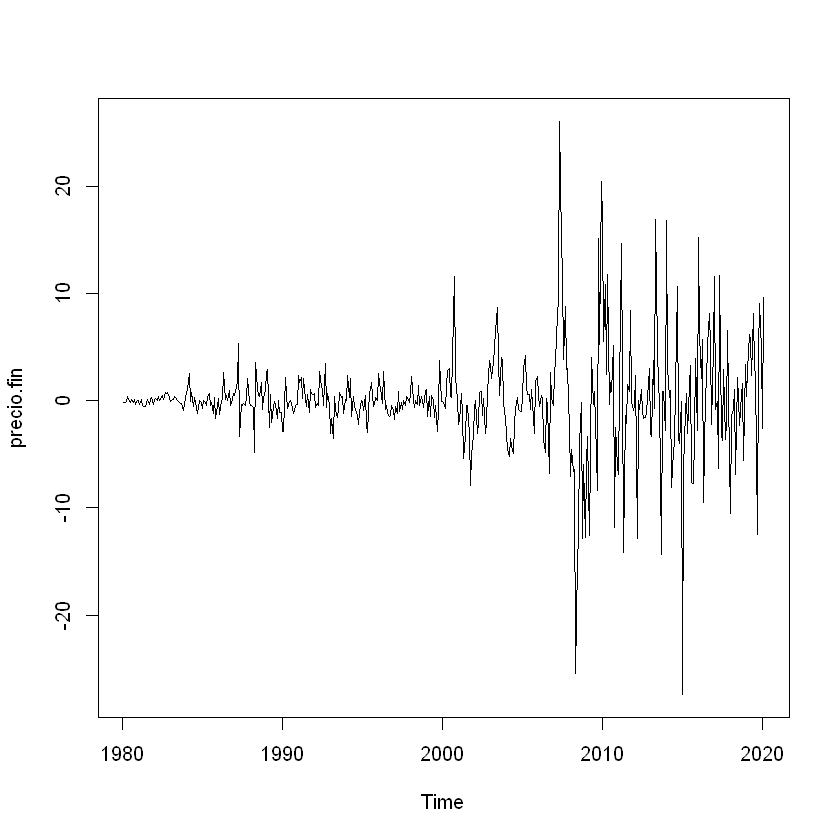

In [7]:
# aplicamos una diferenciación estacional para eliminar la componente estacional, esta es mensual.
precio.fin <- diff(precio.diff,lag=12)
plot(precio.fin)

No es suficiente la diferenciación para solucionar el problema de homocedasticidad

In [8]:
# Se procede a realizar el test de Dickey-Fuller para analizar si la serie es estacionaria

# H0: La serie en primera diferencia es no estacionaria: Tiene raíz unitaria
# H1: La serie en primera diferencia es estacionaria: No Tiene raíz unitaria

library(tseries)
adf.test(precio.fin)

Warning message:
"package 'tseries' was built under R version 4.0.5"
Warning message in adf.test(precio.fin):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  precio.fin
Dickey-Fuller = -6.0732, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [9]:
# Dado que el valor-p < 0.05 rechazamos la hipotesis nula, rechazando la NO estacionalidad.

# Ahora se debe encontrar el modelo ARMA que mejor se ajuste.
# Para esto analizamos el acf y pacf

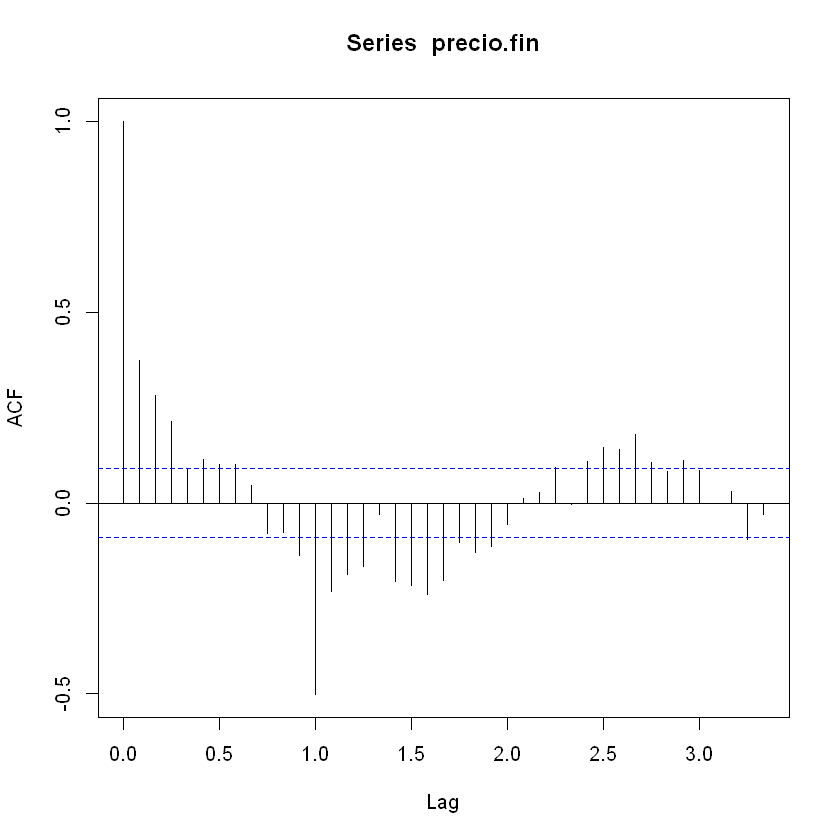

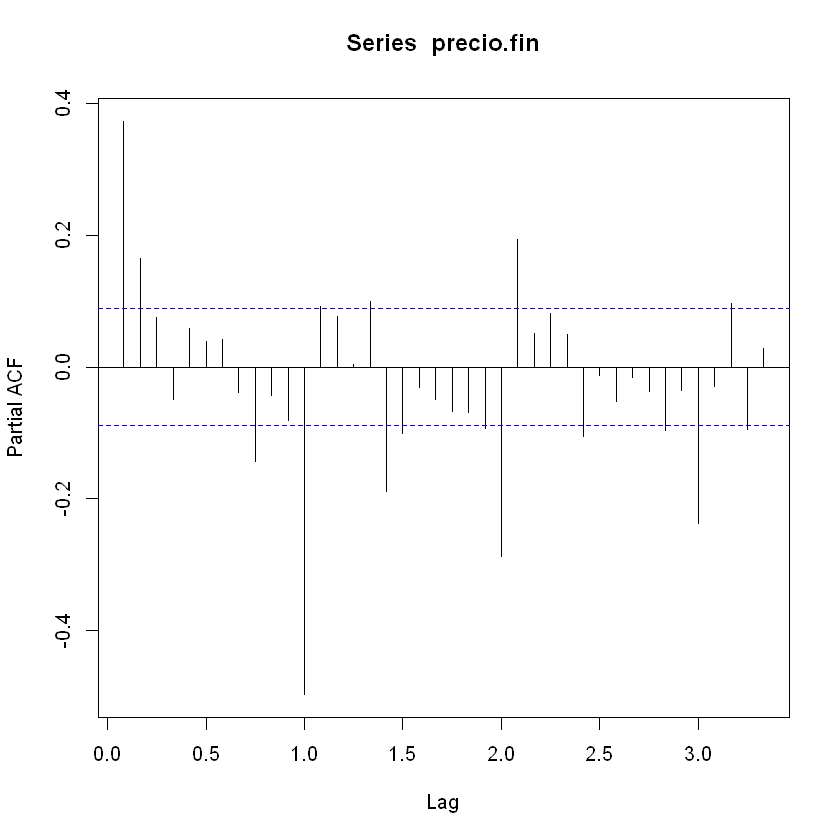

In [10]:
acf(precio.fin, lag.max = 40)
pacf(precio.fin, lag.max = 40)

In [11]:
# el acf da indicios de un posible valor negativo de los parametros theta
#el pacf demuestra que la diferenciacion no fue suficiente para eliminar los 12 resagos esperados

In [12]:
modelo<-auto.arima(Precio2)

summary(modelo)

Series: Precio2 
ARIMA(2,0,1)(0,1,2)[12] with drift 

Coefficients:
         ar1      ar2      ma1     sma1    sma2   drift
      1.7322  -0.7513  -0.4608  -0.9850  0.2428  0.5253
s.e.  0.0678   0.0667   0.0921   0.0555  0.0568  0.0873

sigma^2 estimated as 9.532:  log likelihood=-1232.48
AIC=2478.95   AICc=2479.19   BIC=2508.2

Training set error measures:
                      ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.01163844 3.030661 1.807055 -0.7883804 2.303216 0.1592116
                    ACF1
Training set -0.00839366


---
Era de esperar el componente negativo del valor ma1 pues el acf presentaba valores negativos y positivos, y se utiliza un drift para solucionar el problema que no es capaz de solucionar la diferenciacion de 12

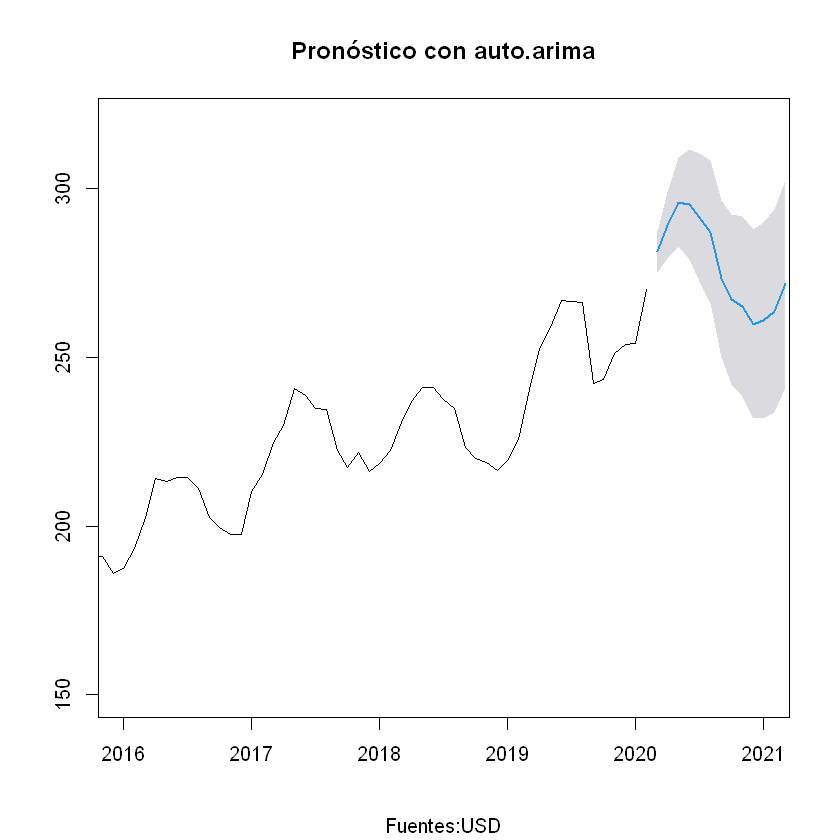

In [13]:
pronostico<-forecast(modelo,13,level=95)
plot(pronostico,main="Pronóstico con auto.arima", sub="Fuentes:USD",xlim=c(2016,2021),ylim=c(150,320))

In [14]:
df_pron = data.frame(seq(as.Date('2020-03-01'),as.Date('2021-03-01'),'months'),pronostico$upper[1:13],c(leche$Precio_leche[495:506],"-"))
colnames(df_pron) = c("Fecha","Valor Pronosticado", "Valor Real")

In [15]:
df_pron

Fecha,Valor Pronosticado,Valor Real
<date>,<dbl>,<chr>
2020-03-01,287.3706,279.88
2020-04-01,298.8525,316.25
2020-05-01,309.2175,318.88
2020-06-01,311.5132,315.76
2020-07-01,310.3844,313.3
2020-08-01,308.4369,309.44
2020-09-01,296.6694,278.99
2020-10-01,292.2554,274.32
2020-11-01,291.6463,288.09


In [16]:
RMSE = sqrt(1/12 * sum((df_pron[1:12,2]-as.numeric(df_pron[1:12,3]))^2))
MAE = 1/12 * sum(abs(df_pron[1:12,2]-as.numeric(df_pron[1:12,3])))
MAE
RMSE

[1] 7.210671

[1] 9.728063

Con lo anterior, sin variables exógenas, es estima bajo un modelo generado por autorima, es decir un modelo ARIMA(2,0,1)(0,1,2)[12] con drift, que el valor esperado para el precio de la leche para el 2021-03 sea de 302.5967, con un error cabsoluto medio (MAE) de los últimos 12 meses de 7.21 y un error cuadrático medio (RMSE) de 9.72